### *Generate_Spectrum*
##### A tool to generate "Spectrum" from "Time-History" of an EarthQuake
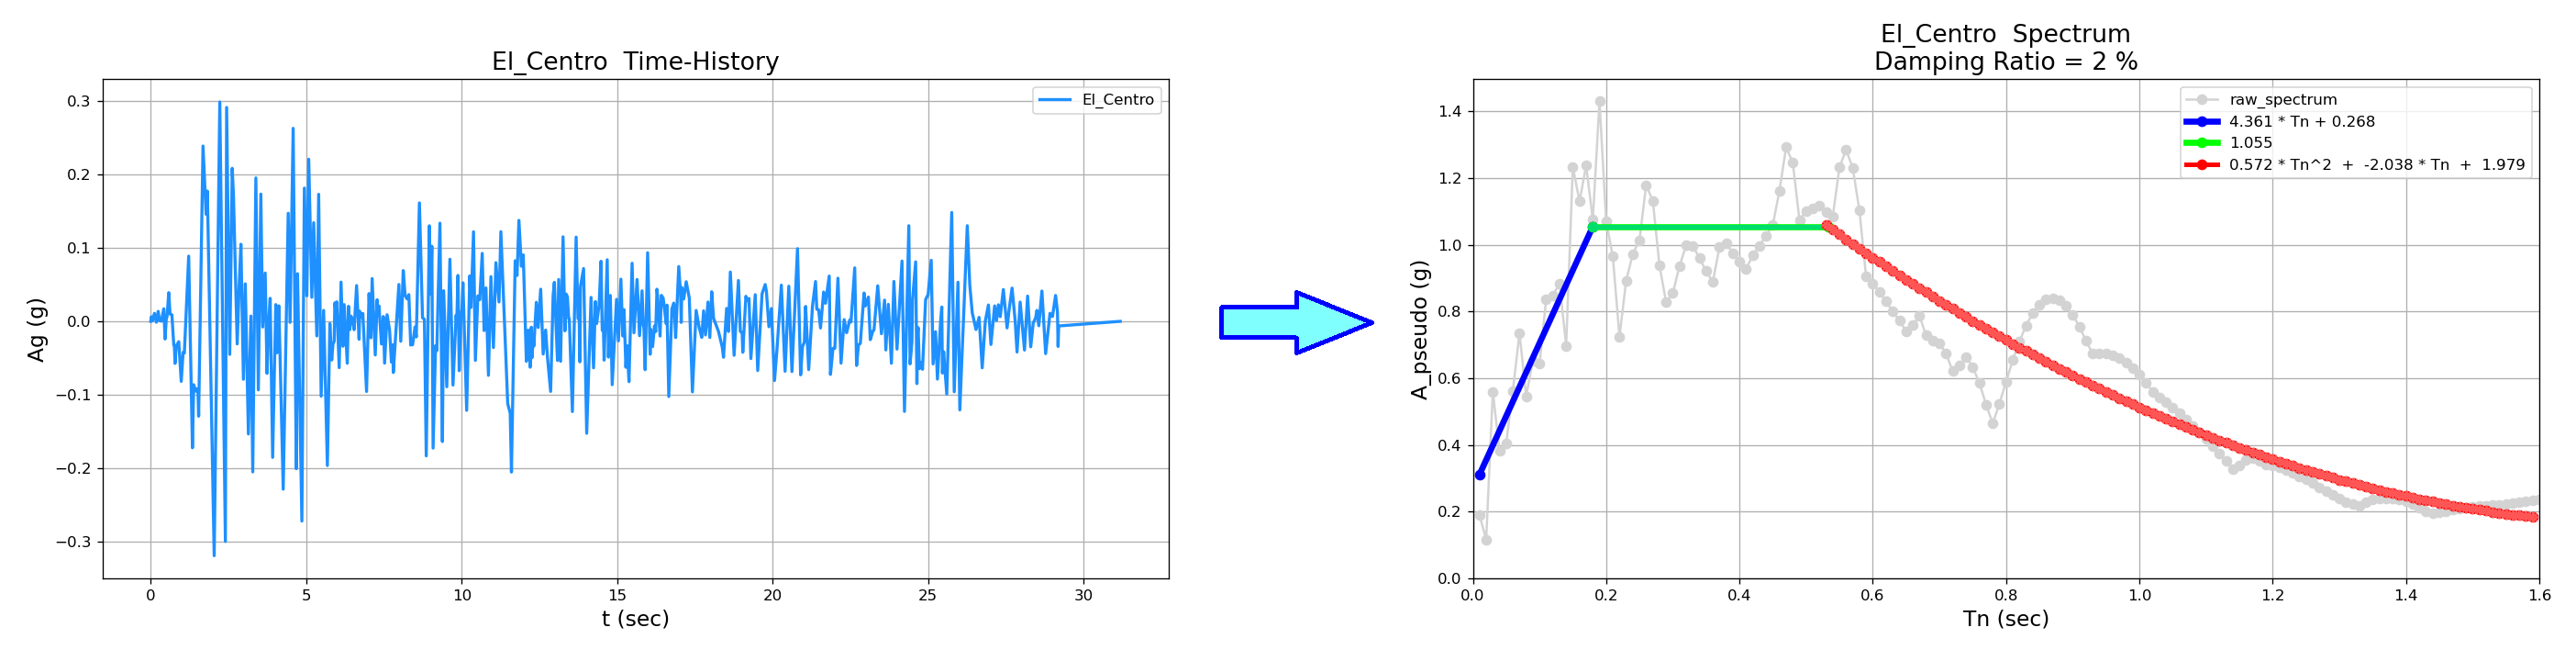

In [1]:
# (auto)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#####   
### reading the Time-History

In [2]:
# (input) Time-History & dt & rD (damping-ratio)

Time_History = pd.read_csv('El_Centro_TH.csv',header=2)

dt = 0.02  # (second)
rD = 0.02  # damping ratio
g  = 9800  # mm/sec2
Tn_Range = np.arange(0.05,1.65,0.05)

Earth_Quake_Name = 'El_Centro'

print( Time_History.head(3) )

   El_Centro
0    0.00000
1    0.00630
2    0.00364


In [3]:
# (auto)  Completing Data 
Ag = g*Time_History.values
t  = np.array( Time_History.index*dt, 'float64' )

#####  
### Visualizing the Ground Acceleration Time-History 

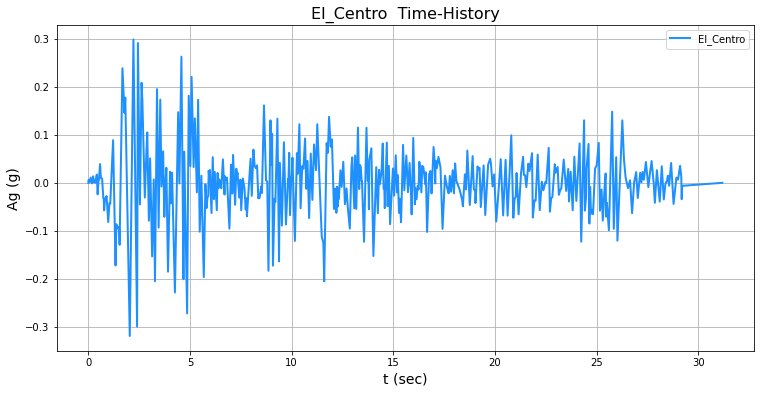

In [4]:
# (auto) plot  
fig,ax = plt.subplots( figsize=(12.5,6) )
### Time-History of Ground acceleration
ax.plot(  t, Ag/g, '-', color='dodgerblue', linewidth=2 )   
# Decoration
plt.title(Earth_Quake_Name+'  Time-History',fontsize=16)
plt.xlabel('t (sec)',fontsize=14)
plt.ylabel('Ag (g)',fontsize=14) 
plt.legend([ Earth_Quake_Name ])
plt.grid('on')
plt.savefig(Earth_Quake_Name+'_TH.png', dpi=120)   
plt.show()

#####  
### Solving The Differential Equation of Motion
### u"  +  2.rD.wn.u' + wn^2.u = -Ag    
 - u:displacement   v:velocity  a:acceleration
 - y = [u, v]            
 - du/dt = v
 - dv/dt = a  = -2.rD.wn.u' - wn^2.u - Ag
#####  

In [5]:
# define a function that solves the Earthquake Differential Equation of Motion:
#
#                     u" + 2.rD.wn.u' + wn**2.u = -Ag
#                 
# for known:
#    damping ratio, rD 
#    natural period, Tn
#    ground-acceleration time-history, Ag(t)
#
# and returns a dataframe ( uva ) containing:
#   displacements, u(t)
#   velocity, v(t) 
#   total acceleration,   a_total(t)   =  (-wn**2)*u(t) + (-2*rD*wn)*v(t)  
#   pseudo acceleration,  a_pseudo(t)  =  (-wn**2)*u(t) 

  
def find_uva(rD,Tn,Ag):
    wn = 2*np.pi/Tn 
    u_All, v_All, a_total_All, a_pseudo_All = [],[],[],[] 
    
    # coeffs:   b:-2*rD*wn  c:-wn**2 
    b, c = -2*rD*wn, -wn**2 
    # Initial displacement & velocity  @  t=0
    u0, v0 = 0, 0        
    y0 = [ u0, v0 ]
    
    for ag in -Ag:  #Time_History['El_Centro'].values: 
        # define  dy/dt  
        def dydt(t, y):
            """ Return dx/dt = f(t, x) at time t. """
            u, v  = y 
            dudt  = v
            dvdt  = b*v + c*u + ag 
            return dudt , dvdt
        
        # Integrate the differential equation.
        soln = solve_ivp(  dydt,  (0,dt),  y0,  dense_output=True,  method='RK45'  )
        
        t = np.linspace( 0,dt, 2 )
        u, v = soln.sol(t)  
        a_total  = +b*v + c*u
        a_pseudo = +c*u
        
        # Initial displacement & velocity  
        u0, v0 = u[-1], v[-1]        
        y0 = [ u0, v0 ] 
        
        # appending
        u_All.append(u)
        v_All.append(v) 
        a_total_All.append(a_total)
        a_pseudo_All.append(a_pseudo)
        
        # uva DataFrame
        Dict={  'u' : np.array(u_All).T[1]
              , 'v' : np.array(v_All).T[1] 
              , 'a_total'  : np.array(a_total_All).T[1]
              , 'a_pseudo' : np.array(a_pseudo_All).T[1] } 
        columns = Dict.keys()
        uva = pd.DataFrame(data=Dict,columns=columns)
        
    return uva

##### 
### Generating and Saving The Raw Spectrum 

In [7]:
# (auto) define a function called Make_Spectrum 
# that solves equation of motion for a range of natural periods, 
# and returns their corresponding pseudu accelerations 

def Make_Spectrum( rD, Tn_Range, Ag ):
    TN, U, V, A, A_total, A_pseudo = [],[],[],[],[],[]
    for Tn in Tn_Range:
        uva = find_uva(rD,Tn,Ag)
        print( '\n\n',Tn,'\n',uva.values )
    
        u_max = max( abs( uva['u'] ))
        v_max = max( abs( uva['v'] )) 
        a_total_max  = max( abs( uva['a_total' ] ))
        a_pseudo_max = max( abs( uva['a_pseudo'] )) 
    
        TN.append( Tn )
        U.append( u_max )
        V.append( v_max ) 
        A_total.append( a_total_max )
        A_pseudo.append( a_pseudo_max )
        
    Dict = { 'Tn (sec)'    : np.array( TN )
           , 'A_ps (g)'    : np.array( A_pseudo ) / g
           , 'A_total (g)' : np.array( A_total  ) / g
           , 'D (mm)'      : np.array( U )
           , 'V (mm/sec)'  : np.array( V ) }
    
    Spectrum_Data = pd.DataFrame( data=Dict, columns=Dict.keys() ) 
    
    return Spectrum_Data

# Making Raw Spectrum
Spectrum_Data = Make_Spectrum( rD, Tn_Range, Ag )
# Checking
print( '\n\n', Spectrum_Data.head(3) )
# Saving Raw Spectrum
Spectrum_Data.to_csv( Earth_Quake_Name+'_Raw_Spectrum.csv' )



 0.05 
 [[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-6.87330382e-03 -2.74723880e-01  1.09919776e+02  1.08538863e+02]
 [ 1.68547487e-05  5.38573797e-01 -2.97332670e+00 -2.66159523e-01]
 ...
 [ 2.68034023e-04 -3.35231014e-02 -4.06411815e+00 -4.23262364e+00]
 [-2.86848325e-04  9.95845583e-03  4.47967052e+00  4.52972718e+00]
 [ 2.61769545e-04  1.23764967e-02 -4.19591003e+00 -4.13369897e+00]]


 0.1 
 [[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-1.06328014e-02 -9.11432625e-01  4.42672974e+01  4.19766173e+01]
 [-2.30037609e-02 -1.64358791e-01  9.12282866e+01  9.08152079e+01]
 ...
 [-9.64934300e-03 -2.87434125e-01  3.88164800e+01  3.80940793e+01]
 [-7.23065225e-03  4.89698297e-01  2.73147249e+01  2.85454709e+01]
 [ 4.91816690e-03  5.59843824e-01 -2.08231857e+01 -1.94161447e+01]]


 0.15000000000000002 
 [[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-1.15151552e-02 -1.07719853e+00  2.20093127e+01  2.02044492e+01]
 [-3.3



 1.05 
 [[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-1.23136161e-02 -1.22891053e+00  7.35078393e-01  4.40927056e-01]
 [-4.38011931e-02 -1.91553980e+00  2.02693953e+00  1.56843700e+00]
 ...
 [ 1.15621982e+01  5.03078558e+01 -4.26061875e+02 -4.14020215e+02]
 [ 1.24811001e+01  4.14796824e+01 -4.56852892e+02 -4.46924338e+02]
 [ 1.32176010e+01  3.20899700e+01 -4.80978063e+02 -4.73297026e+02]]


 1.1 
 [[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-1.23158142e-02 -1.22930507e+00  6.82696467e-01  4.01825502e-01]
 [-4.38281542e-02 -1.91797630e+00  1.86819024e+00  1.42997204e+00]
 ...
 [-4.71327348e+00  1.34722266e+02  1.22997719e+02  1.53778991e+02]
 [-2.00002567e+00  1.36306162e+02  3.41112612e+01  6.52544203e+01]
 [ 7.26983025e-01  1.36098223e+02 -5.48147727e+01 -2.37191235e+01]]


 1.1500000000000001 
 [[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-1.23177685e-02 -1.22965479e+00  6.36437701e-01  3.67702086e-01]
 [-4.38

##### 
### Importing Raw Spectrum (optional)  

In [1]:
# Making Raw Spectrum is time-taking and may be done in several rounds:
#  - Round 1:  Tn from 0.01 to 1.0  =>  saving the results
#  - Round 2:  Tn from 2.01 to 2.0  =>  saving the results
#  - Round 3:  Tn from 2.01 to 3.0  =>  saving the results
#  - ...
# and combined into 1 csv file, eg:  'El_Centro_Raw_SPEC.csv'
#
# Now we import this file:



#Spectrum_Data = pd.read_csv('El_Centro_Raw_SPEC_Full.csv')
#print( Spectrum_Data.head(3) )

#Tn_Range = Spectrum_Data['Tn (sec)']

##### 
### Visualizing Raw Spectrum 

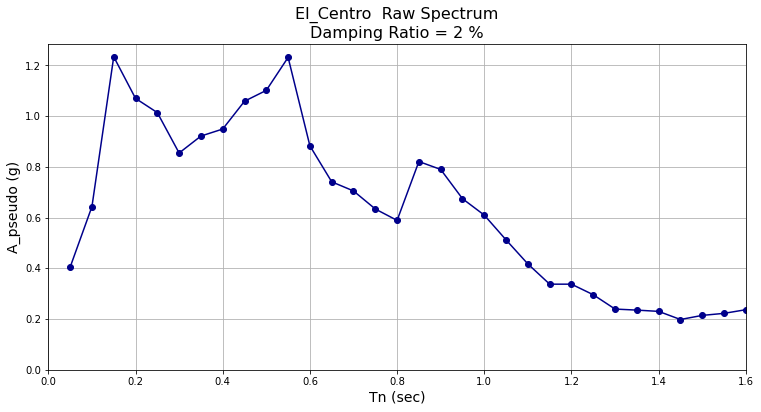

In [9]:
# (auto) plot  Raw_Spectrum
fig,ax = plt.subplots( figsize=(12.5,6) )
ax.plot(  Spectrum_Data['Tn (sec)'], Spectrum_Data['A_ps (g)'], '-o', color='darkblue', linewidth=1.5 )  
plt.title(Earth_Quake_Name+'  Raw Spectrum\nDamping Ratio = '+str(int(rD*100))+' %',fontsize=16)
plt.xlabel('Tn (sec)',fontsize=14)
plt.ylabel('A_pseudo (g)',fontsize=14)
plt.xlim(0,max(Tn_Range))  
plt.ylim(0,) 
plt.grid('on')
plt.savefig(Earth_Quake_Name+'_Raw_Spectrum.png', dpi=120)   
plt.show()

##### 
### Defining 3 Major Parts of Spectrum:
 - Part 1: Displacement-Ralated: a_pseudo = a + b.Tn  
 - Part 2: Velocity-Related: a_pseudo = Mean
 - Part 3: Acceleration-Related: a_pseudo = A.Tn^2 + B.Tn + C

In [10]:
# (input) 
# Defining preliminary range of each Part
# overlaps are considered to synchronize final pieces

Part_1_Init, Part_1_End = 0.01, 0.22
Part_2_Init, Part_2_End = 0.15, 0.58 
Part_3_Init, Part_3_End = 0.47, 1.60

In [11]:
# (auto)
# Part 1:   Displacement-Related-Part
# A straight line (regression-line) will represent this part:  a_pseudo=a+b*Tn
#
# define a function called  find_linear_reg_line
# to find a & b of regression-line  a_seudo=a+b*Tn  for Part_1 

def find_linear_reg_line( Init, End, Spectrum_Data ):
    D = Spectrum_Data.loc[ :, ['Tn (sec)','A_ps (g)'] ].copy()    # keeping the parts needed
    D = D[ D['Tn (sec)'] >= Init ]
    D = D[ D['Tn (sec)'] <= End  ]  
    
    N =D.shape[0]
    x =D['Tn (sec)'];  Sx=sum(x);    Mx=Sx/N
    y =D['A_ps (g)'];  Sy=sum(y);    My=Sy/N
    x2=x*x;            Sx2=sum(x2) 
    xy=x*y;            Sxy=sum(xy) 
    
    b = (N*Sxy-Sx*Sy) / (N*Sx2-Sx**2)
    a = My - b*Mx
    
    #  s = a + bt
    a_ps_Init = a + b*Init
    a_ps_End  = a + b*End
    
    return [ a,b ] 


[a,b] = find_linear_reg_line( Part_1_Init, Part_1_End, Spectrum_Data )
print(a,b)
[a_ps_Init, a_ps_End] =  a+b*Part_1_Init,  a+b*Part_1_End 

0.19128336543309077 5.1734884922307245


In [12]:
# (auto) 
# Part 2:   Velocity-Related-Part
# average (Mean) of all values will represent this part:  a_pseudo=Mean
#
# define a function called  find_mean
# that finds the mean of Part_2:  a_pseudo=mean

def find_mean( Init, End, Spectrum_Data ):
    D = Spectrum_Data.loc[ :, ['Tn (sec)','A_ps (g)'] ].copy()    # keeping the parts needed
    D = D[ D['Tn (sec)'] >= Init ]
    D = D[ D['Tn (sec)'] <= End  ] 
    Mean = np.mean( D['A_ps (g)'] )
    return Mean

Mean = find_mean( Part_2_Init, Part_2_End, Spectrum_Data )
print(Mean)

1.0483509826733834


In [13]:
# (auto)
# Part 3:   Acceleration-Related Part
# a second-order parabola will represent this part:  a_pseudo = A*Tn^2 + B*Tn + C

# define a function called  find_quad_reg_line  that finds A,B,C   

def find_quad_reg_line( Init, End, Spectrum_Data ):
    D = Spectrum_Data.loc[ :, ['Tn (sec)','A_ps (g)'] ].copy()    # keeping the parts needed
    D = D[ D['Tn (sec)'] >= Init ]
    D = D[ D['Tn (sec)'] <= End  ]  
    
    N = D.shape[0]
    
    # mean
    x  = D['Tn (sec)'];  Sx=sum(x);          
    y  = D['A_ps (g)'];  Sy=sum(y);        
    
    x2 = x*x;            Sx2=sum(x2);     
    x3 = x*x*x;          Sx3=sum(x3);    
    x4 = x*x*x*x;        Sx4=sum(x4);     
    
    xy = x*y;            Sxy=sum(xy);     
    x2y= x*x*y;          Sx2y=sum(x2y);   
    
    #  Sx4 * A  +  Sx3 * B  +  Sx2 * C  =  Sx2y            [A]   
    #  Sx3 * A  +  Sx2 * B  +  Sx  * C  =  Sxy     =>    a [B] = b    =>    s = At^2 + Bt + C
    #  Sx2 * A  +  Sx  * B  +  N   * C  =  Sy              [C]   
    
    ## Gauss Ellimination  ax=b => x=?
    a = np.array([ [ Sx4, Sx3, Sx2 ],
                   [ Sx3, Sx2, Sx  ],
                   [ Sx2, Sx,  N   ]], 'float64' )
    b = np.array( [ Sx2y,
                    Sxy,
                    Sy  ], 'float64' )
    n = len(b)
    x = np.zeros(n,'float64')

    #    Forward Elimination
    for k in range(n-1):
        for i in range(k+1,n):
            fctr = a[i,k] / a[k,k]
            for j in range(k,n):
                a[i,j] = a[i,j] - fctr*a[k,j]
            b[i] = b[i] - fctr*b[k]
        
    #    Back Substitution
    x[n-1] = b[n-1] / a[n-1,n-1]
    for i in range(n-2,-1,-1):
        Sum = b[i]
        for j in range(i+1,n):
            Sum = Sum - a[i,j]*x[j]
        x[i] = Sum / a[i,i]
     
    return x

[A,B,C] = find_quad_reg_line( Part_3_Init, Part_3_End, Spectrum_Data ) 
X_Range = np.arange( Part_3_Init, Part_3_End+0.01, 0.01 )
Y_Range = A*X_Range**2 + B*X_Range + C
print(A,B,C)

0.5415535067299542 -1.9623165332471026 1.9367699372367655


In [14]:
# (auto) Finding Intersection of 3 Parts
Left_Inter =(Mean-a)/b;                           Left_Inter=np.round(Left_Inter,3)
Right_Inter=(-B-(B**2-4*A*(C-Mean))**.5)/(2*A);   Right_Inter=np.round(Right_Inter,3)

In [15]:
# (auto) Making Corrections for Part_3
X_Range = np.arange( np.round( Right_Inter,2 ), Part_3_End, 0.01 )
Y_Range = A*X_Range**2 + B*X_Range + C

##### 
### Visualizing Spectrum 

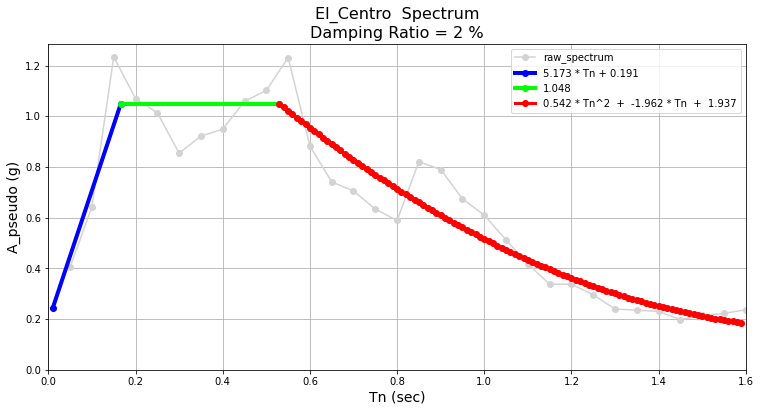

In [16]:
# (auto) plot  
fig,ax = plt.subplots( figsize=(12.5,6) )
### Raw_Spectrum
ax.plot(  Spectrum_Data['Tn (sec)'], Spectrum_Data['A_ps (g)'], '-o', color='lightgray', linewidth=1.5 )   
### Modified Spectrum
# Part_1
ax.plot(  [Part_1_Init, Left_Inter], [a_ps_Init,Mean], '-o', color='blue', linewidth=4 )   
# Part_2
ax.plot(  [Left_Inter, Right_Inter], [Mean,Mean], '-o', color='lime', linewidth=4 )
# Part_3
ax.plot(  X_Range, Y_Range, '-o', color='red', linewidth=3 ) 
# Decoration
plt.title(Earth_Quake_Name+'  Spectrum\nDamping Ratio = '+str(int(rD*100))+' %',fontsize=16)
plt.xlabel('Tn (sec)',fontsize=14)
plt.ylabel('A_pseudo (g)',fontsize=14)
plt.xlim(0,1.6)
plt.ylim(0,)
plt.legend([  'raw_spectrum'
            , str(np.round(b,3))+' * Tn' + ' + ' + str(np.round(a,3)) 
            , str(np.round(Mean,3))
            , str(np.round(A,3))+' * Tn^2  +  ' + str(np.round(B,3))+' * Tn  +  ' + str(np.round(C,3)) ])
plt.grid('on')
plt.savefig(Earth_Quake_Name+'_Spectrum.png', dpi=120)   
plt.show()

##### 
### making & Saving Final Spectrum DataFrame 

In [22]:
# (input) Making The Final Spectrum DataFrame

Dict={ 'From Tn (sec)': np.array( np.round([0.01,Left_Inter,Right_Inter],3), 'float64' )
     , 'To Tn (sec)'  : np.array( np.round([Left_Inter,Right_Inter,Part_3_End],3), 'float64' )
     , 'a_pseudo (g)'     : np.array([ 
           str(np.round(b,3)) + ' * Tn  +  '   + str(np.round(a,3)) 
         , str(np.round(Mean,3))
         , str(np.round(A,3)) + ' * Tn^2  +  ' + str(np.round(B,3))
           +' * Tn  +  ' + str(np.round(C,3)) ],'str') 
     }

Final_Spectrum = pd.DataFrame(data=Dict,columns=Dict.keys())
Final_Spectrum.index = ['Part_1','Part_2','Part_3']
# Saving Spectrum_Data
Final_Spectrum.to_csv( Earth_Quake_Name+'_Final_Spectrum.csv' )

print( Final_Spectrum )

        From Tn (sec)  To Tn (sec)                            a_pseudo (g)
Part_1          0.010        0.166                    5.173 * Tn  +  0.191
Part_2          0.166        0.530                                   1.048
Part_3          0.530        1.600  0.542 * Tn^2  +  -1.962 * Tn  +  1.937


##### 